In [ ]:
# cell-collective-find-isolated-attractors.ipynb
#
# Bryan Daniels, Enrico Borriello
# 2024/1/10
#
# Find and count the number of attractors with basin size 1 in cell collective networks
# (using the preimage function).
#

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from toolbox.simplePickle import load,save

In [2]:
# useful code for dealing with cell collective networks from from code/cellCollective.py
def directory_name(n_name):
    """
    Returns the name of the Cell Collective directory given
    the "nice" name with spaces
    """
    return n_name.replace(' ','_').replace('.','')
    
def nice_name(dir_name):
    """
    Returns the "nice" name of the Cell Collective network
    given the directory name
    """
    nice = dir_name.replace('_',' ')
    if nice == 'Iron Acquisition And Oxidative Stress Response In Aspergillus Fumigatus':
        nice = nice+'.'
    return nice

### Load Cell Collective control kernel data from 2021 paper

In [3]:
control_kernel_data_file = '/Users/bdaniel6/ASUDropbox/Research/grn-survey/Writeups/control-kernel-2020/'\
    'Nature Comm final revision Aug 2021/zenodo Aug 2021/20200820_control_kernel_supplemental_info.csv'
ck_df = pd.read_csv(control_kernel_data_file).set_index('name')

# include expected average ck size and difference from expected
ck_df['expected mean control kernel size'] = np.log2(ck_df['number of attractors'])
ck_df['difference from expected mean control kernel size'] = \
    ck_df['mean control kernel size'] - ck_df['expected mean control kernel size']

print("We have exact control kernel data for {} networks.".format((1-ck_df['uses sampling method']).sum()))

We have exact control kernel data for 44 networks.


In [4]:
print("For {} networks, we only have sampled attractors:".format(ck_df['uses sampling method'].sum()))
for name in ck_df[ck_df['uses sampling method']].index:
    print(" - {}".format(name))

For 5 networks, we only have sampled attractors:
 - FA BRCA Pathway
 - Lymphoid And Myeloid Cell Specification And Transdifferentiation
 - Bordetella Bronchiseptica
 - Cholesterol Regulatory Pathway
 - Pc12 Cell Differentiation


### Load basin data from newer Cell Collective runs

In [5]:
datadir = '../code/'

In [6]:
# concatenate all csv file data
df_list = []
for filename in glob.glob(datadir+'basin_entropy_data*.csv'):
    df_single = pd.read_csv(filename)
    df_list.append(df_single)
df = pd.concat(df_list).set_index('name')
#df = df.apply(pd.to_numeric,errors='coerce')
# make everything numeric except for "elapsed_time"
numeric_cols = df.columns[df.columns != 'elapsed_time']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric,errors='coerce')
df.head()

,network_size,num_states,num_samples,num_attractors,basin_entropy_NSB,std_basin_entropy_NSB,elapsed_time
name,,,,,,,
Budding_Yeast_Cell_Cycle,20,1048576,10000,33,4.692749,0.008449,0:00:18.083787
Mammalian_Cell_Cycle,20,1048576,10000,3,1.014787,0.003261,0:00:02.020575
HCC1954_Breast_Cell_Line_Long-term_ErbB_Network,25,33554432,10000,9452,8.269992,0.021576,0:11:16.461616
Cortical_Area_Development,5,32,10000,2,0.568464,0.155180,0:00:00.808031
B_Cell_Differentiation,22,4194304,10000,61,5.440223,0.008863,0:00:04.590949


In [7]:
# gather all detailed basin data into a dictionary
basinDataDict = {}
for name in df.index:
    data = load('{}basin_entropy_data_{}.pkl'.format(datadir,name))
    basinDataDict[name] = data

### Load all Cell Collective networks into Neet

In [8]:
# from cellCollective.py
from neet.boolean import LogicNetwork
import os
def load_cell_collective_network(directory):
    """
    Creates neet network from cell collective data in the
    given directory.
    """
    expressions_file = '{}/expressions.txt'.format(directory)
    external_file = '{}/external.txt'.format(directory)
    net = LogicNetwork.read_logic(expressions_file, external_file)
    return net

def load_all_cell_collective_networks(main_directory,
    skip=['ErbB_Receptor_Signaling']):
    """
    Returns dictionary of all cell collective networks
    located in subdirectories of the given main directory.
    
    skip (['ErbB_Receptor_Signaling']) : List of network names
                                         to skip
    """
    netDict = {}
    for directory in glob.glob(main_directory+"/*"):
        name = os.path.split(directory)[-1]
        if os.path.isdir(directory) and name not in skip:
            net = load_cell_collective_network(directory)
            netDict[name] = net
    return netDict

In [9]:
CELL_COLLECTIVE_DIR = '/Users/bdaniel6/ASUDropbox/Research/control-continuous/Data/Cell Collective/'
netDict = load_all_cell_collective_networks(CELL_COLLECTIVE_DIR)

### Load control kernel data for all Cell Collective attractors from 2020 data

In [10]:
# modified from grn-survey/scripts/modularity/load_control_kernel_data.py
def loadDataExact(dir='.'):
    dataDict = {}
    dataForFrame = [] #dataDictForFrame = {}
    for filename in glob.glob(dir+'/control_kernel_*.dat'):
        if filename.find('split') == -1: # we don't want to include "split" data
            try:
                d = load(filename)
                success = True
            except:
                print("loadDataExact: Error loading file {}".format(filename))
                success = False
        else:
            success = False
            
        if success:
            # attempting to cure problems with loading python 2 data
            for key in list(d.keys()):
                if type(key) == bytes:
                    d[key.decode()] = d[key]
        
            dataDict[d['name']] = d
            
            # 2023/12/11 we will skip creating the dataFrame for now
            #ddata = dataFrameExact(d)
            #
            #if len(ddata) > 0:
            #    dataForFrame.append(ddata) #dataDictForFrame[d['name']] = ddata

    #df = pd.DataFrame.from_records(dataForFrame) #,'index') # from_dict
    #df.set_index('name',inplace=True)
    return dataDict #,df

In [11]:
exactDataDir = '/Users/bdaniel6/ASUDropbox/Shared/GRNs/DATA/20200820-control-kernels/'
dataDictExact = loadDataExact(exactDataDir)

In [12]:
# 2024/1/19 also include networks for which we don't have sampled basin data from 2023 but do have
# attractor data from 2020
for name in dataDictExact:
    if directory_name(name) not in basinDataDict:
        print("Adding attractor data for {}...".format(name))
        ckData = dataDictExact[name]
        basinDataDict[directory_name(name)] = {'name': directory_name(ckData['name']),
                                               'network_size': ckData['size'],
                                               'attractors': ckData['attractors'],
                                               'num_attractors': len(ckData['attractors']),
                                               }

Adding attractor data for Budding Yeast Cell Cycle 2009...
Adding attractor data for Arabidopsis Thaliana Cell Cycle...
Adding attractor data for Septation Initiation Network...
Adding attractor data for Tumour Cell Invasion And Migration...
Adding attractor data for Mammalian Cell Cycle 2006...
Adding attractor data for Treatment Of Castration-Resistant Prostate Cancer...
Adding attractor data for Guard Cell Abscisic Acid Signaling...
Adding attractor data for Fanconi Anemia And Checkpoint Recovery...
Adding attractor data for Yeast Apoptosis...
Adding attractor data for T-Cell Signaling 2006...


# Find all isolated attractors in each analyzed network

In [13]:
import preimages
import importlib
importlib.reload(preimages)
import tqdm

In [14]:
def isolated_list(net,attractors,basin_samples=None):
    """
    Returns a list of Boolean values of length number of attractors
    corresponding to whether each attractor is "isolated"
    (has basin of size 1).
    
    basin_samples (None)        : Optionally give list of basin samples to avoid computing
                                  preimages of attractors that we already know are not isolated.
    """
    if basin_samples is None:
        basin_samples = np.zeros(len(attractors))
    assert(len(attractors)==len(basin_samples))
    
    is_isolated_list = []
    for i,att in enumerate(tqdm.tqdm(attractors)):
        if len(att) > 1 or basin_samples[i] > 1:
            is_isolated_list.append(False)
        else:
            decoded_att = net.decode(att[0])
            is_isolated_list.append(len(preimages.preimages(net,decoded_att))==1)
    return is_isolated_list

In [23]:
net_name = 'Cortical_Area_Development'

net = netDict[net_name]
isolated_list(net,
              basinDataDict[net_name]['attractors'],
              basinDataDict[net_name]['sampled_basin_freqs'])

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 9478.65it/s]


[False, False]

In [24]:
net.table

[((3, 2), {'00'}),
 ((0, 2, 4, 3), {'1000'}),
 ((2, 3, 1), {'110'}),
 ((2, 1), {'10'}),
 ((3, 0, 1), {'100'})]

In [26]:
[[net.decode(state) for state in att ] for att in net.attractors]

[[[1, 1, 0, 0, 0]], [[0, 0, 1, 1, 1]]]

In [27]:
net.names

['Coup_fti', 'Emx2', 'Fgf8', 'Sp8', 'Pax6']

In [28]:
net.basin_sizes

array([28,  4])

In [15]:
# compute isolated fixed points (or load from files)
recompute_all = False
recompute_unfinished = False
skip = ['Yeast_Apoptosis',]

if recompute_unfinished or recompute_all:
    for net_name in basinDataDict:
        if recompute_all or (recompute_unfinished and 'is_isolated_list' not in basinDataDict[net_name]):
            if net_name not in skip:
                print("Computing for network {}...".format(net_name))
                net = netDict[net_name]
                if 'sampled_basin_freqs' in basinDataDict[net_name]:
                    is_isolated_list = isolated_list(net,
                                                     basinDataDict[net_name]['attractors'],
                                                     basinDataDict[net_name]['sampled_basin_freqs'])
                else:
                    is_isolated_list = isolated_list(net,
                                                     basinDataDict[net_name]['attractors'])
                basinDataDict[net_name]['is_isolated_list'] = is_isolated_list
    # save basin data dictionaries
    for name in basinDataDict:
        save(basinDataDict[name],'{}basin_entropy_data_{}_with_isolated.pkl'.format(datadir,name))
else:
    # load basin data dictionaries with isolated fixed point data
    for net_name in basinDataDict:
        basinDataDict[net_name] = load('{}basin_entropy_data_{}_with_isolated.pkl'.format(datadir,net_name))

In [16]:
# compute number of isolated fixed points for each network
for net_name in basinDataDict:
    if 'is_isolated_list' in basinDataDict[net_name]:
        ck_df.loc[nice_name(net_name),'number of isolated fixed points'] = \
            np.sum(basinDataDict[net_name]['is_isolated_list'])

In [17]:
print("We have isolated fixed point data for {} networks.".format(ck_df['number of isolated fixed points'].count()))
print()
print("{} network is missing because it takes too long to run:".format(len(skip)))
for name in skip:
    print(" - {}".format(name))
print()
print("{} networks are missing because we only have sampled attractors:".format(ck_df['uses sampling method'].sum()))
for name in ck_df[ck_df['uses sampling method']].index:
    print(" - {}".format(name))

We have isolated fixed point data for 43 networks.

1 network is missing because it takes too long to run:
 - Yeast_Apoptosis

5 networks are missing because we only have sampled attractors:
 - FA BRCA Pathway
 - Lymphoid And Myeloid Cell Specification And Transdifferentiation
 - Bordetella Bronchiseptica
 - Cholesterol Regulatory Pathway
 - Pc12 Cell Differentiation


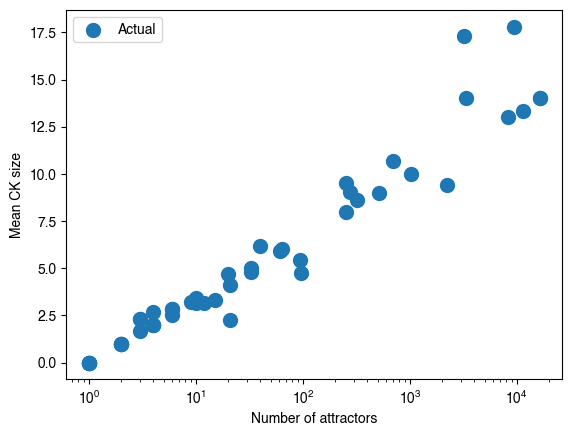

In [122]:
r = ck_df['number of attractors']
s = ck_df['number of isolated fixed points']
n = ck_df['size']
predicted_ck = (r - s)/(r)*np.log2(r) + n*s/r
actual_ck = ck_df['mean control kernel size']
plt.scatter(r,actual_ck,label='Actual',s=100)
#plt.scatter(r,predicted_ck,label='Predicted')

plt.xlabel('Number of attractors')
plt.ylabel('Mean CK size')
plt.legend()
plt.xscale('log')
plt.savefig('240119_ck_size_vs_num_attractors_cell_collective.pdf')

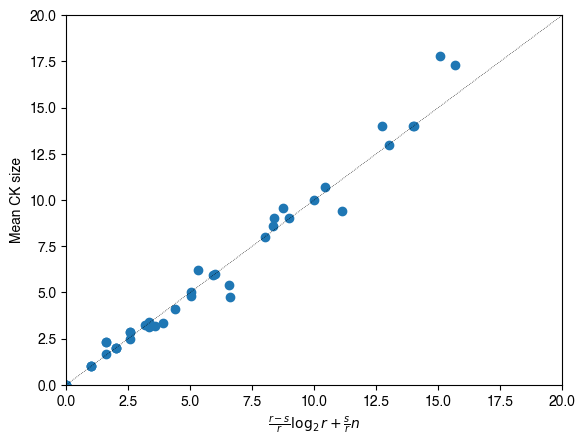

In [123]:
plt.scatter(predicted_ck,actual_ck)
plt.xlabel('$\\frac{r-s}{r} \log_2{r} + \\frac{s}{r} n$')
plt.ylabel('Mean CK size')
sizemin,sizemax = 0,20
plt.plot([sizemin,sizemax],[sizemin,sizemax],'k:',lw=0.5)
plt.axis([sizemin,sizemax,sizemin,sizemax])
plt.savefig('240119_actual_versus_predicted_mean_ck_size.pdf')

# 2024/1/23 output relevant data for variance computations

In [21]:
print("Including data for {} networks.".format(len(ck_df)))

Including data for 49 networks.


In [20]:
columns_to_save = ['mean control kernel size',
                   'number of attractors',
                   'size',
                   'number of isolated fixed points']
ck_df[columns_to_save].to_csv('240123_cell_collective_ck_and_isolated_fp_data.csv')

# 2024/1/12 histogram of CK sizes for isolated fixed points

In [126]:
relative_ck_sizes_isolated = []
relative_ck_sizes_nonisolated = []
for name in basinDataDict:
    ck_sizes = dataDictExact[nice_name(name)]['control_kernel_sizes']
    net_size = basinDataDict[name]['network_size']
    if 'is_isolated_list' in basinDataDict[name]:
        isolated = basinDataDict[name]['is_isolated_list']
        relative_ck_sizes_isolated.extend([ ck_sizes[i]/net_size for i in range(len(ck_sizes)) if isolated[i] ])
        relative_ck_sizes_nonisolated.extend(
            [ ck_sizes[i]/net_size for i in range(len(ck_sizes)) if (not isolated[i]) and (ck_sizes[i] is not None) ])

        # also save proportion of isolated fixed points
        ck_df.loc[nice_name(name),'proportion_of_isolated_fixed_points'] = np.mean(isolated) 

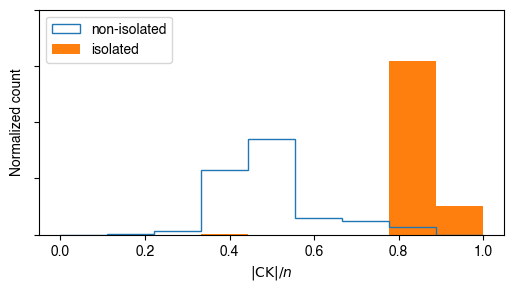

In [132]:
plt.figure(figsize=(6,3))

bins = np.linspace(0,1,10)
plt.hist(relative_ck_sizes_nonisolated,density=True,bins=bins,histtype='step',label='non-isolated')
plt.hist(relative_ck_sizes_isolated,density=True,bins=bins,label='isolated')
plt.legend()
plt.yticks([0,2.5,5,7.5,10],[])
plt.xlabel('$|\mathrm{CK}|/n$')
plt.ylabel('Normalized count')
plt.subplots_adjust(bottom=0.2,top=0.95)
plt.savefig('240119_ck_histogram_isolated_vs_nonisolated.pdf')

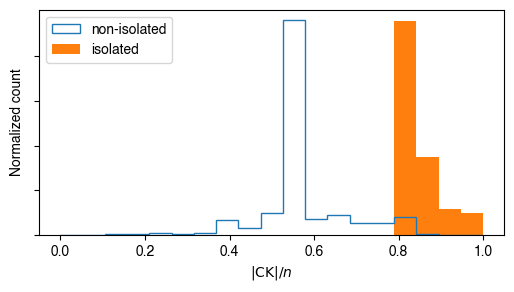

In [71]:
plt.figure(figsize=(6,3))

bins = np.linspace(0,1,20)
plt.hist(relative_ck_sizes_nonisolated,density=True,bins=bins,histtype='step',label='non-isolated')
plt.hist(relative_ck_sizes_isolated,density=True,bins=bins,label='isolated')
plt.legend()
plt.yticks([0,2.5,5,7.5,10],[])
plt.xlabel('$|\mathrm{CK}|/n$')
plt.ylabel('Normalized count')
plt.subplots_adjust(bottom=0.2,top=0.95)
plt.savefig('240116_ck_histogram_isolated_vs_nonisolated.pdf')

Text(0, 0.5, 'Difference from $\\log_2 r$')

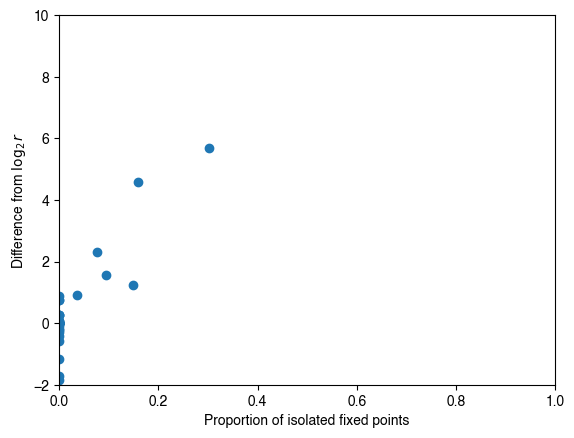

In [130]:
plt.scatter(ck_df['proportion_of_isolated_fixed_points'],
            ck_df['difference from expected mean control kernel size'])
plt.axis(xmin=0,xmax=1.,ymin=-2,ymax=10)
plt.xlabel('Proportion of isolated fixed points')
plt.ylabel('Difference from $\log_2 r$')